📘 Lineares Regressionsmodell zur Umsatzvorhersage

1. 📦 Pakete & Daten laden

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from workalendar.europe import Germany
import matplotlib.pyplot as plt
from itertools import product


# Datenquellen
base_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/"
df_umsatz = pd.read_csv(base_url + "umsatzdaten_gekuerzt.csv")
df_wetter = pd.read_csv(base_url + "wetter.csv")
df_kiwo = pd.read_csv(base_url + "kiwo.csv")
df_ferien = pd.read_csv("../../data/ferien_sh.csv", parse_dates=["Startdatum", "Enddatum"])


# Alle Datum-Warengruppe-Kombis
alle_daten = pd.date_range(start="2013-07-01", end="2019-07-31", freq="D")
warengruppen = [1, 2, 3, 4, 5, 6]
voll_kombis = pd.DataFrame(list(product(alle_daten, warengruppen)), columns=["Datum", "Warengruppe"])

# Wetterdaten mergen
df_wetter["Datum"] = pd.to_datetime(df_wetter["Datum"])
df = voll_kombis.merge(df_wetter, on="Datum", how="left")

# KiWo
df_kiwo["Datum"] = pd.to_datetime(df_kiwo["Datum"])
df_kiwo["KielerWoche"] = 1
df = df.merge(df_kiwo[["Datum", "KielerWoche"]], on="Datum", how="left").fillna({"KielerWoche": 0})

# Umsatzdaten
df_umsatz["Datum"] = pd.to_datetime(df_umsatz["Datum"])
df = df.merge(df_umsatz, on=["Datum", "Warengruppe"], how="left")
df["Umsatz"] = df["Umsatz"].fillna(0)


# ID
df["id"] = df.apply(lambda row: int(row["Datum"].strftime("%y%m%d") + str(row["Warengruppe"])), axis=1)

# Kalenderfeatures
df["Wochentag"] = df["Datum"].dt.dayofweek
df["Monat"] = df["Datum"].dt.month
df["IstWochenende"] = df["Wochentag"].isin([5, 6]).astype(int)


2. 📅 Feiertage & Ferien ergänzen

In [2]:
cal = Germany(subdivision="SH")
jahre = df['Datum'].dt.year.unique()
feiertage_set = set()
for jahr in jahre:
    feiertage_set.update([d for d, _ in cal.holidays(jahr)])

df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)

ferien_tage = set()
for _, row in df_ferien.iterrows():
    ferientage = pd.date_range(start=row['Startdatum'], end=row['Enddatum'])
    ferien_tage.update(ferientage)

df['Ferienzeit'] = df['Datum'].isin(ferien_tage).astype(int)

print(df.dtypes)
print(df.head())

Datum                  datetime64[ns]
Warengruppe                     int64
Bewoelkung                    float64
Temperatur                    float64
Windgeschwindigkeit           float64
Wettercode                    float64
KielerWoche                   float64
id                              int64
Umsatz                        float64
Wochentag                       int32
Monat                           int32
IstWochenende                   int64
Feiertag                        int64
Ferienzeit                      int64
dtype: object
       Datum  Warengruppe  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01            1         6.0     17.8375                 15.0   
1 2013-07-01            2         6.0     17.8375                 15.0   
2 2013-07-01            3         6.0     17.8375                 15.0   
3 2013-07-01            4         6.0     17.8375                 15.0   
4 2013-07-01            5         6.0     17.8375                 15.0   

   Wetter

/tmp/ipykernel_57342/1852788460.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)


### 3. 🧼 Fehlende Werte behandeln
Reihenfolge der Imputation:

Wettercode – Größter Fehlwertanteil (~25 %), stark vernetzt mit anderen Wetterdaten → zuerst mit KNN imputieren.

Bewölkung – Moderate Lücke, hängt mit Wettercode und Temperatur zusammen → danach ergänzen.

Temperatur & Windgeschwindigkeit – Geringe Lücken, durch Monatsmedian oder KNN sinnvoll auffüllbar → zuletzt.

#### Wettercode mit kNN


In [3]:

import numpy as np
from sklearn.impute import KNNImputer

# 0.0 als fehlend markieren
df['Wettercode'] = df['Wettercode'].replace(0.0, np.nan)
print("fehlende Werte vor kNN:", df['Wettercode'].isna().sum())  
fehlende_idx = df[df['Wettercode'].isna()].index
print(fehlende_idx)


# Relevante Features fürs Imputing
knn_features = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Monat']

df_knn = df[['Wettercode'] + knn_features]

# KNN-Imputer anwenden
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = imputer.fit_transform(df_knn)

# Ergebnis zurück in DataFrame schreiben
# Runden und casten zu int, falls Wettercode kategorisch ist
df['Wettercode'] = np.round(df_knn_imputed[:, 0]).astype(int)

print("fehlende Werte nach kNN:", df['Wettercode'].isna().sum())  # sollte 0 sein
fehlende_idx = df[df['Wettercode'].isna()].index
print(fehlende_idx)






fehlende Werte vor kNN: 4452
Index([    6,     7,     8,     9,    10,    11,    24,    25,    26,    27,
       ...
       13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295],
      dtype='int64', length=4452)
fehlende Werte nach kNN: 0
Index([], dtype='int64')


In [4]:
print("fehlende Werte vor kNN:", df['Bewoelkung'].isna().sum())  
fehlende_idx = df[df['Bewoelkung'].isna()].index
print(fehlende_idx)

# 2. Bewoelkung imputieren
df_bew = df[['Bewoelkung', 'Temperatur', 'Wettercode', 'Monat', 'Windgeschwindigkeit']]
df[['Bewoelkung']] = KNNImputer(n_neighbors=5).fit_transform(df_bew)[:, 0:1]

print("fehlende Werte nach kNN:", df['Bewoelkung'].isna().sum())  # sollte 0 sein
fehlende_idx = df[df['Bewoelkung'].isna()].index
print(fehlende_idx)


fehlende Werte vor kNN: 156
Index([ 7554,  7555,  7556,  7557,  7558,  7559,  9336,  9337,  9338,  9339,
       ...
       11630, 11631, 11632, 11633, 12618, 12619, 12620, 12621, 12622, 12623],
      dtype='int64', length=156)
fehlende Werte nach kNN: 0
Index([], dtype='int64')


In [5]:
print("fehlende Werte vor kNN:", df['Temperatur'].isna().sum())  
fehlende_idx = df[df['Temperatur'].isna()].index
print(fehlende_idx)

# 3. Temperatur imputieren
df_temp = df[['Temperatur', 'Bewoelkung', 'Wettercode', 'Monat', 'Windgeschwindigkeit']]
df[['Temperatur']] = KNNImputer(n_neighbors=5).fit_transform(df_temp)[:, 0:1]

print("fehlende Werte nach kNN:", df['Temperatur'].isna().sum())  # sollte 0 sein
fehlende_idx = df[df['Temperatur'].isna()].index
print(fehlende_idx)


fehlende Werte vor kNN: 96
Index([ 7554,  7555,  7556,  7557,  7558,  7559,  9336,  9337,  9338,  9339,
        9340,  9341,  9342,  9343,  9344,  9345,  9346,  9347, 11370, 11371,
       11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381,
       11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
       11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431,
       11432, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441,
       11442, 11443, 11444, 11445, 11446, 11447, 11580, 11581, 11582, 11583,
       11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11622, 11623,
       11624, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633,
       12618, 12619, 12620, 12621, 12622, 12623],
      dtype='int64')


fehlende Werte nach kNN: 0
Index([], dtype='int64')


In [6]:
print("fehlende Werte vor kNN:", df['Windgeschwindigkeit'].isna().sum())  
fehlende_idx = df[df['Windgeschwindigkeit'].isna()].index
print(fehlende_idx)

# 4. Windgeschwindigkeit imputieren
df_wind = df[['Windgeschwindigkeit', 'Temperatur', 'Bewoelkung', 'Wettercode', 'Monat']]
df[['Windgeschwindigkeit']] = KNNImputer(n_neighbors=5).fit_transform(df_wind)[:, 0:1]

print("fehlende Werte nach kNN:", df['Windgeschwindigkeit'].isna().sum())  # sollte 0 sein
fehlende_idx = df[df['Windgeschwindigkeit'].isna()].index
print(fehlende_idx)


fehlende Werte vor kNN: 96
Index([ 7554,  7555,  7556,  7557,  7558,  7559,  9336,  9337,  9338,  9339,
        9340,  9341,  9342,  9343,  9344,  9345,  9346,  9347, 11370, 11371,
       11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381,
       11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
       11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431,
       11432, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441,
       11442, 11443, 11444, 11445, 11446, 11447, 11580, 11581, 11582, 11583,
       11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11622, 11623,
       11624, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633,
       12618, 12619, 12620, 12621, 12622, 12623],
      dtype='int64')
fehlende Werte nach kNN: 0
Index([], dtype='int64')


4. ✂️ Datensplit

In [7]:
# Korrigierter Split
train = df[(df['Datum'] >= "2013-07-01") & (df['Datum'] <= "2017-07-31")]
val   = df[(df['Datum'] >= "2017-08-01") & (df['Datum'] <= "2018-07-31")]
test  = df[(df['Datum'] >= "2018-08-01") & (df['Datum'] <= "2019-07-31")]
print(test.shape)
print(test['Datum'].min(), test['Datum'].max())



(2190, 14)
2018-08-01 00:00:00 2019-07-31 00:00:00


5. 🤖 Modell trainieren & evaluieren

In [8]:
# nur Temperatur

import statsmodels.api as sm
import scipy.stats as stats

# Nur Temperatur verwenden
X_train = train[["Temperatur"]]
y_train = train["Umsatz"]

# Intercept hinzufügen (statsmodels verlangt expliziten konstanten Term)
X_train = sm.add_constant(X_train)

# Modell trainieren (OLS = Ordinary Least Squares)
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     213.4
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           8.79e-48
Time:                        22:01:50   Log-Likelihood:                -57788.
No. Observations:                8952   AIC:                         1.156e+05
Df Residuals:                    8950   BIC:                         1.156e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.9846      3.258     41.124      0.0

In [9]:
#ohne Warengruppe

# One-Hot-Encoding von Warengruppe, Drop First verhindert Multikollinearität
features = [ 'Temperatur',  'Wettercode',
            'KielerWoche',  'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit'] 

X_train = pd.get_dummies(train[features], 
                         columns=[ "Wettercode", "Monat"], drop_first=True)
X_train = X_train.astype(float)
#print(X_train.dtypes)
X_train = X_train.astype(float)

# Intercept hinzufügen
X_train = sm.add_constant(X_train)

# Zielvariable
y_train = train["Umsatz"]

# Modell trainieren
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())




                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     13.01
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           4.22e-84
Time:                        22:01:50   Log-Likelihood:                -57633.
No. Observations:                8952   AIC:                         1.154e+05
Df Residuals:                    8910   BIC:                         1.156e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           127.7989      8.244     15.503

In [10]:
#mit Warengruppe

# One-Hot-Encoding von Warengruppe, Drop First verhindert Multikollinearität
features = [ 'Temperatur',  'Wettercode', 'Warengruppe',
            'KielerWoche',  'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit'] 

X_train = pd.get_dummies(train[features], 
                         columns=[ "Warengruppe","Wettercode", "Monat"], drop_first=True)
X_train = X_train.astype(float)
#print(X_train.dtypes)
X_train = X_train.astype(float)

# Intercept hinzufügen
X_train = sm.add_constant(X_train)

# Zielvariable
y_train = train["Umsatz"]

# Modell trainieren
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     571.9
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:01:51   Log-Likelihood:                -51740.
No. Observations:                8952   AIC:                         1.036e+05
Df Residuals:                    8905   BIC:                         1.039e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            71.4737      4.655     15.354

## Normalisieren

In [11]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler



# ---------------------------------------
# 1. Features festlegen
# ---------------------------------------
features = ['Warengruppe', 'Temperatur', 'Wettercode',
            'KielerWoche', 'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit']

# ---------------------------------------
# 2. One-Hot-Encoding für kategorische Features
#    Drop First verhindert Multikollinearität
# ---------------------------------------
X_train = pd.get_dummies(train[features], 
                         columns=["Warengruppe", "Wettercode", "Monat"], drop_first=True)

X_train = X_train.astype(float)
# ---------------------------------------
# 3. Numerische Features normalisieren
# ---------------------------------------
numerische_features = [ 'Temperatur']

scaler = StandardScaler()
X_train[numerische_features] = scaler.fit_transform(X_train[numerische_features])

# ---------------------------------------
# 4. Intercept hinzufügen
# ---------------------------------------
X_train = sm.add_constant(X_train)

# ---------------------------------------
# 5. Zielvariable definieren
# ---------------------------------------
y_train = train["Umsatz"]

# ---------------------------------------
# 6. Modell trainieren
# ---------------------------------------
model = sm.OLS(y_train, X_train)
results = model.fit()

# ---------------------------------------
# 7. Zusammenfassung anzeigen
# ---------------------------------------
print(results.summary())


### Wettercode hat nur minimalen Einfluss
### normalisieren hat keinen großen Einfluss auf die Ergebnisse



                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     571.9
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:01:51   Log-Likelihood:                -51740.
No. Observations:                8952   AIC:                         1.036e+05
Df Residuals:                    8905   BIC:                         1.039e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            79.0917      4.672     16.929

### Modellgleichung

In [12]:
# Koeffizienten (inkl. Intercept)
coeffs = results.params

# Gleichung als String zusammenbauen
equation = f"Umsatz = {coeffs['const']:.4f}"
for var, coef in coeffs.drop('const').items():
    sign = " + " if coef >= 0 else " - "
    equation += f"{sign}{abs(coef):.4f} * {var}"

print(equation)


Umsatz = 79.0917 + 4.3905 * Temperatur + 28.5912 * KielerWoche + 43.2149 * IstWochenende - 58.4144 * Feiertag + 22.5371 * Ferienzeit + 283.4428 * Warengruppe_2 + 41.9469 * Warengruppe_3 - 35.4827 * Warengruppe_4 + 156.3464 * Warengruppe_5 - 108.3018 * Warengruppe_6 - 3.0625 * Wettercode_10 + 68.9141 * Wettercode_15 + 1.5572 * Wettercode_16 - 20.7814 * Wettercode_17 - 9.4688 * Wettercode_20 - 9.2348 * Wettercode_21 - 12.3854 * Wettercode_22 + 1.3942 * Wettercode_28 + 10.5072 * Wettercode_32 - 43.1844 * Wettercode_34 - 11.9094 * Wettercode_45 - 2.2624 * Wettercode_49 - 29.0633 * Wettercode_53 - 7.0032 * Wettercode_61 - 4.8336 * Wettercode_62 - 7.8242 * Wettercode_63 + 2.7284 * Wettercode_65 - 1.0666 * Wettercode_69 - 10.1923 * Wettercode_71 - 18.3074 * Wettercode_73 + 19.3964 * Wettercode_75 - 5.3515 * Wettercode_77 - 36.5489 * Wettercode_79 + 24.0704 * Wettercode_88 - 7.8338 * Wettercode_95 + 21.8901 * Monat_2 + 8.4450 * Monat_3 + 14.7590 * Monat_4 + 28.9806 * Monat_5 + 34.1853 * Monat_

### Lag-Features
Lag-Features fügen frühere Umsatzwerte als zusätzliche Eingaben hinzu, damit das Modell zeitliche Abhängigkeiten und Trends besser erfassen kann.

In [13]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np




# ---------------------------------------
# Funktion: Lag- und Zusatzfeatures erstellen ( Umsatz von 1 Tag und 7 Tagen vorher)
# ---------------------------------------
def create_features(df):
    df['Temperatur_2'] = df['Temperatur'] ** 2
    df['Umsatz_lag_1'] = df['Umsatz'].shift(1)
    df['Umsatz_lag_7'] = df['Umsatz'].shift(7)
    return df

# Funktion: Lag-Features über vergangene Daten korrekt erzeugen
def prepare_lag_features(df, prev_df, lags=[1, 7]):
    df_full = pd.concat([prev_df.tail(max(lags)), df], ignore_index=True)
    df_full = create_features(df_full)
    return df_full.iloc[max(lags):].copy()

# ---------------------------------------
# Train-Set vorbereiten
# ---------------------------------------
train = create_features(train)
train = train.dropna(subset=['Umsatz_lag_1', 'Umsatz_lag_7'])

# Features definieren
features = ['Warengruppe', 'Temperatur', 'Temperatur_2', 'Wettercode',
            'KielerWoche', 'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit',
            'Umsatz_lag_1', 'Umsatz_lag_7']

numerische_features = ['Temperatur', 'Temperatur_2', 'Umsatz_lag_1', 'Umsatz_lag_7']

# One-Hot-Encoding
X_train = pd.get_dummies(train[features], 
                         columns=["Warengruppe", "Wettercode", "Monat"], drop_first=True)
X_train = X_train.astype(float)

# Numerische Features skalieren
scaler = StandardScaler()
X_train[numerische_features] = scaler.fit_transform(X_train[numerische_features])

# Intercept-Spalte hinzufügen
X_train = sm.add_constant(X_train)

# Zielvariable
y_train = train["Umsatz"]

# Modell trainieren
model = sm.OLS(y_train, X_train)
results = model.fit()

# Modell-Zusammenfassung
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     553.6
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:01:51   Log-Likelihood:                -51592.
No. Observations:                8945   AIC:                         1.033e+05
Df Residuals:                    8895   BIC:                         1.036e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           111.7489      5.423     20.606

/tmp/ipykernel_57342/3422621892.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temperatur_2'] = df['Temperatur'] ** 2
/tmp/ipykernel_57342/3422621892.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Umsatz_lag_1'] = df['Umsatz'].shift(1)
/tmp/ipykernel_57342/3422621892.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [14]:


# ---------------------------------------
# Val- und Testdaten vorbereiten
# ---------------------------------------
val = prepare_lag_features(val, train)
test = prepare_lag_features(test, val)

# One-Hot-Encoding
X_val = pd.get_dummies(val[features], columns=["Warengruppe", "Wettercode", "Monat"], drop_first=True)
X_test = pd.get_dummies(test[features], columns=["Warengruppe", "Wettercode", "Monat"], drop_first=True)
# Ohne const (für Skalierung und Reindex)
X_val = X_val.reindex(columns=X_train.columns.drop("const"), fill_value=0)
X_test = X_test.reindex(columns=X_train.columns.drop("const"), fill_value=0)

# Numerische Features skalieren
X_val[numerische_features] = scaler.transform(X_val[numerische_features])
X_test[numerische_features] = scaler.transform(X_test[numerische_features])

# const hinzufügen und Spalten exakt wie X_train anordnen
X_val = sm.add_constant(X_val, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add')

# 🔐 Sicherstellen, dass Reihenfolge 100% stimmt
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]


# Skalierung anwenden (mit train-Scaler)
X_val[numerische_features] = scaler.transform(X_val[numerische_features])
X_test[numerische_features] = scaler.transform(X_test[numerische_features])


# Zielvariablen
y_val = val["Umsatz"]
y_test = test["Umsatz"]

# Vorhersagen
val_pred = results.predict(X_val)
test_pred = results.predict(X_test)

# Evaluation
print("Validation R²:", r2_score(y_val, val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_pred)))

print("Test R²:", r2_score(y_test, test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))


Validation R²: 0.6834889130631596
Validation RMSE: 78.32108692509208
Test R²: 0.0
Test RMSE: 199.11883811884522


🟦 1. Visualisierung: Vorhergesagt vs. Tatsächlich

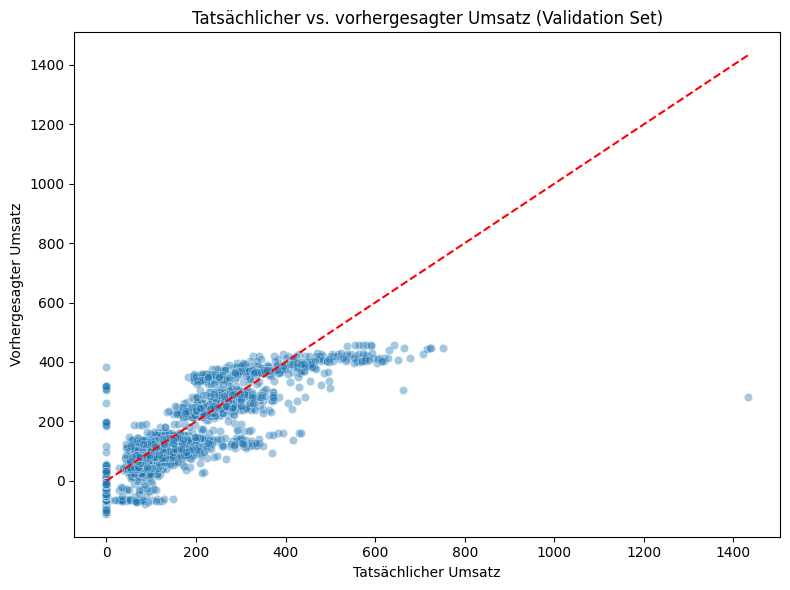

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=val["Umsatz"], y=val_pred, alpha=0.4)
plt.xlabel("Tatsächlicher Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Tatsächlicher vs. vorhergesagter Umsatz (Validation Set)")

# Diagonale einzeichnen
max_val = max(val["Umsatz"].max(), val_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

plt.tight_layout()
plt.show()


🟨 2. Einfluss der Merkmale (Koeffizienten)

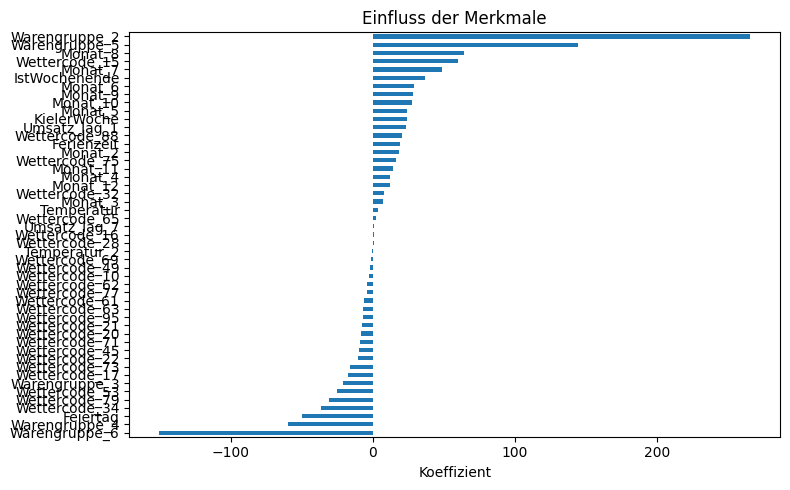

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Koeffizienten aus statsmodels Ergebnissen holen (inkl. Intercept)
coeffs = results.params

# Falls du nur die Merkmale ohne den Intercept sehen möchtest:
coeffs = coeffs.drop('const', errors='ignore')

# Koeffizienten sortieren für bessere Lesbarkeit
coeffs = coeffs.sort_values()

# Balkendiagramm plotten
coeffs.plot(kind="barh", figsize=(8, 5), title="Einfluss der Merkmale")
plt.xlabel("Koeffizient")
plt.tight_layout()
plt.show()


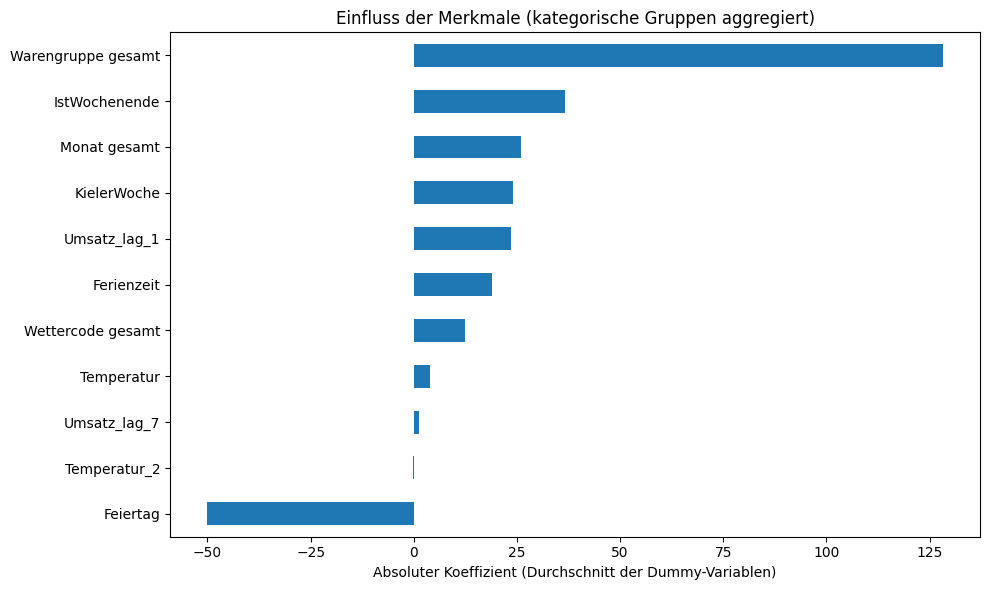

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Koeffizienten (ohne Intercept)
coeffs = results.params.drop('const', errors='ignore')

# Gruppen-Features definieren
gruppen = {
    'Wettercode': [col for col in coeffs.index if col.startswith('Wettercode_')],
    'Warengruppe': [col for col in coeffs.index if col.startswith('Warengruppe_')],
    'Monat': [col for col in coeffs.index if col.startswith('Monat_')]
}

# Aggregierte Koeffizienten speichern
agg_coeffs = coeffs.copy()

for gruppe, cols in gruppen.items():
    if cols:
        # Durchschnitt des absoluten Einflusses der Dummy-Variablen der Gruppe
        mean_abs = coeffs[cols].abs().mean()
        # Entferne einzelne Dummies der Gruppe aus der Übersicht
        agg_coeffs = agg_coeffs.drop(cols)
        # Füge aggregierten Wert als neue Zeile hinzu
        agg_coeffs[gruppe + ' gesamt'] = mean_abs

# Sortieren für bessere Visualisierung
agg_coeffs = agg_coeffs.sort_values()

# Plot
agg_coeffs.plot(kind='barh', figsize=(10,6), title='Einfluss der Merkmale (kategorische Gruppen aggregiert)')
plt.xlabel('Absoluter Koeffizient (Durchschnitt der Dummy-Variablen)')
plt.tight_layout()
plt.show()
